In [1]:
%pip install --upgrade poutyne # to install lastest poutyne version, if it's not already
import math
import os
import tarfile
import urllib.request
from shutil import copyfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils import model_zoo
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder

from poutyne import set_seeds, Model, ModelCheckpoint, CSVLogger, Experiment

Also, we need to set Pythons's, NumPy's and PyTorch's seeds by using Poutyne function so that our training is (almost) reproducible.

In [2]:
set_seeds(42)

In [3]:
def download_and_extract_dataset(path):
    os.makedirs(path, exist_ok=True)
    tgz_filename = os.path.join(path, "images.tgz")
    
    print("Downloading dataset...")
    urllib.request.urlretrieve("https://graal.ift.ulaval.ca/public/CUB200.tgz", tgz_filename)
    print("Extracting archive...")
    archive = tarfile.open(tgz_filename)
    archive.extractall(path)

In [4]:
def copy(source_path, filenames, dest_path):
    for filename in filenames:
        source = os.path.join(source_path, filename)
        dest = os.path.join(dest_path, filename)
        copyfile(source, dest)

def split_train_valid_test(dataset_path, train_path, valid_path, test_path, train_split=0.6, valid_split=0.2): # test_split=0.2
    for classname in sorted(os.listdir(dataset_path)):
        if classname.startswith('.'):
            continue
        train_class_path = os.path.join(train_path, classname)
        valid_class_path = os.path.join(valid_path, classname)
        test_class_path = os.path.join(test_path, classname)

        os.makedirs(train_class_path, exist_ok=True)
        os.makedirs(valid_class_path, exist_ok=True)
        os.makedirs(test_class_path, exist_ok=True)

        dataset_class_path = os.path.join(dataset_path, classname)
        filenames = sorted(filename for filename in os.listdir(dataset_class_path) if not filename.startswith('.'))
        np.random.shuffle(filenames)

        num_examples = len(filenames)
        train_last_idx = math.ceil(num_examples*train_split)
        valid_last_idx = train_last_idx + math.floor(num_examples*valid_split)
        train_filenames = filenames[0:train_last_idx]
        valid_filenames = filenames[train_last_idx:valid_last_idx]
        test_filenames = filenames[valid_last_idx:]
        copy(dataset_class_path, train_filenames, train_class_path)
        copy(dataset_class_path, valid_filenames, valid_class_path)
        copy(dataset_class_path, test_filenames, test_class_path)

We do the split train/valid/test.

In [5]:
base_path = './datasets/CUB200'
dataset_path = os.path.join(base_path, 'images')
train_path = os.path.join(base_path, 'train')
valid_path = os.path.join(base_path, 'valid')
test_path = os.path.join(base_path, 'test')

In [6]:
download_and_extract_dataset(base_path)
split_train_valid_test(dataset_path, train_path, valid_path, test_path)

Extracting archive...


Now, let's set our training constants. We first have the CUDA device used for training if one is present. Secondly, we set the number of classes (i.e. one for each number). Finally, we set the batch size (i.e. the number of elements to see before updating the model), the learning rate for the optimizer, and the number of epochs (i.e. the number of times we see the full dataset).


In [7]:
# Training constants
cuda_device = 0
device = torch.device("cuda:%d" % cuda_device if torch.cuda.is_available() else "cpu")

num_classes = 200
batch_size = 64
learning_rate = 0.1
n_epoch = 30

Creation of the PyTorch's datasets for our problem.

In [8]:
norm_coefs = {}
norm_coefs['cub200'] = [(0.47421962,  0.4914721 ,  0.42382449), (0.22846779,  0.22387765,  0.26495799)]
norm_coefs['imagenet'] = [(0.485, 0.456, 0.406), (0.229, 0.224, 0.225)]
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(*norm_coefs['cub200'])
])

train_set = ImageFolder(train_path, transform=transform)
valid_set = ImageFolder(valid_path, transform=transform)
test_set = ImageFolder(test_path, transform=transform)

train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=8, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, num_workers=8)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=8)

We load a pretrained `ResNet-18` networks and replace the head with the number of neurons equal to our number of classes.

In [9]:
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

We freeze the network except for its head.

In [10]:
def freeze_weights(resnet18):
    for name, param in resnet18.named_parameters():
        if not name.startswith('fc.'):
            param.requires_grad = False

freeze_weights(resnet18)

We define callbacks for saving last epoch, best epoch and logging the results.

In [11]:
# We are saving everything into ./saves/cub200.
save_base_dir = 'saves'
save_path = os.path.join(save_base_dir, 'cub200')
os.makedirs(save_path, exist_ok=True)

callbacks = [
    # Save the latest weights to be able to resume the optimization at the end for more epochs.
    ModelCheckpoint(os.path.join(save_path, 'last_epoch.ckpt')),

    # Save the weights in a new file when the current model is better than all previous models.
    ModelCheckpoint(os.path.join(save_path, 'best_epoch_{epoch}.ckpt'), monitor='val_acc', mode='max', 
                    save_best_only=True, restore_best=True, verbose=True),

    # Save the losses and accuracies for each epoch in a TSV.
    CSVLogger(os.path.join(save_path, 'log.tsv'), separator='\t'),
]

Finally, we start the training and output its final test loss, accuracy, and micro F1-score.

> Note that the F1-score is quite similar to the accuracy since the dataset is very balanced.

In [12]:
optimizer = optim.SGD(resnet18.fc.parameters(), lr=learning_rate, weight_decay=0.001)
loss_function = nn.CrossEntropyLoss()

model = Model(resnet18, optimizer, loss_function, 
              batch_metrics=['accuracy'], epoch_metrics=['f1'],
              device=device)

model.fit_generator(train_loader, valid_loader, epochs=n_epoch, callbacks=callbacks)

test_loss, (test_acc, test_f1) = model.evaluate_generator(test_loader)

Epoch:  1/30 Train steps: 58 Val steps: 18 5.13s loss: 4.971728 acc: 4.487699 fscore_micro: 0.044877 val_loss: 4.306483 val_acc: 12.743363 val_fscore_micro: 0.127434
Epoch 1: val_acc improved from -inf to 12.74336, saving file to saves/cub200/best_epoch_1.ckpt
Epoch:  2/30 Train steps: 58 Val steps: 18 4.87s loss: 3.715159 acc: 24.709381 fscore_micro: 0.247094 val_loss: 3.612310 val_acc: 20.707965 val_fscore_micro: 0.207080
Epoch 2: val_acc improved from 12.74336 to 20.70796, saving file to saves/cub200/best_epoch_2.ckpt
Epoch:  3/30 Train steps: 58 Val steps: 18 4.91s loss: 2.893865 acc: 42.930522 fscore_micro: 0.429305 val_loss: 3.142848 val_acc: 30.353982 val_fscore_micro: 0.303540
Epoch 3: val_acc improved from 20.70796 to 30.35398, saving file to saves/cub200/best_epoch_3.ckpt
Epoch:  4/30 Train steps: 58 Val steps: 18 4.96s loss: 2.355975 acc: 55.258178 fscore_micro: 0.552582 val_loss: 2.839871 val_acc: 36.371681 val_fscore_micro: 0.363717
Epoch 4: val_acc improved from 30.35398 

Epoch: 26/30 Train steps: 58 Val steps: 18 5.40s loss: 0.366069 acc: 98.972695 fscore_micro: 0.989727 val_loss: 1.978603 val_acc: 51.327434 val_fscore_micro: 0.513274
Epoch 26: val_acc improved from 51.06195 to 51.32743, saving file to saves/cub200/best_epoch_26.ckpt
Epoch: 27/30 Train steps: 58 Val steps: 18 4.98s loss: 0.350929 acc: 99.161936 fscore_micro: 0.991619 val_loss: 1.977024 val_acc: 52.212389 val_fscore_micro: 0.522124
Epoch 27: val_acc improved from 51.32743 to 52.21239, saving file to saves/cub200/best_epoch_27.ckpt
Epoch: 28/30 Train steps: 58 Val steps: 18 5.04s loss: 0.345045 acc: 99.053798 fscore_micro: 0.990538 val_loss: 1.977225 val_acc: 51.769912 val_fscore_micro: 0.517699
Epoch: 29/30 Train steps: 58 Val steps: 18 4.95s loss: 0.322397 acc: 99.297107 fscore_micro: 0.992971 val_loss: 1.975152 val_acc: 51.504425 val_fscore_micro: 0.515044
Epoch: 30/30 Train steps: 58 Val steps: 18 5.06s loss: 0.316426 acc: 99.459313 fscore_micro: 0.994593 val_loss: 1.971837 val_acc: 

In [13]:
logs = pd.read_csv(os.path.join(save_path, 'log.tsv'), sep='\t')
print(logs)

best_epoch_idx = logs['val_acc'].idxmax()
best_epoch = int(logs.loc[best_epoch_idx]['epoch'])
print("Best epoch: %d" % best_epoch)

    epoch      time   lr      loss        acc  fscore_micro  val_loss  \
0       1  5.127235  0.1  4.971728   4.487699      0.044877  4.306483   
1       2  4.868146  0.1  3.715159  24.709381      0.247094  3.612310   
2       3  4.910415  0.1  2.893865  42.930522      0.429305  3.142848   
3       4  4.963105  0.1  2.355975  55.258178      0.552582  2.839871   
4       5  5.088407  0.1  1.950990  64.368748      0.643687  2.631912   
5       6  4.970546  0.1  1.669538  71.208435      0.712084  2.502099   
6       7  5.190205  0.1  1.468114  75.804271      0.758043  2.401000   
7       8  5.269884  0.1  1.290188  79.562044      0.795620  2.307899   
8       9  5.122114  0.1  1.147733  83.184645      0.831846  2.255263   
9      10  4.910460  0.1  1.041504  86.131387      0.861314  2.192490   
10     11  4.961812  0.1  0.940394  87.510138      0.875101  2.188433   
11     12  4.850869  0.1  0.863334  89.213301      0.892133  2.125058   
12     13  5.104850  0.1  0.792032  90.646121      

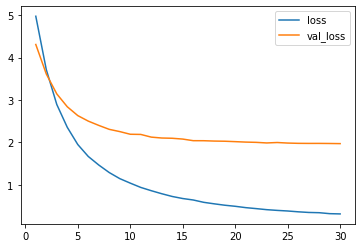

In [14]:
metrics = ['loss', 'val_loss']
plt.plot(logs['epoch'], logs[metrics])
plt.legend(metrics)
plt.show()

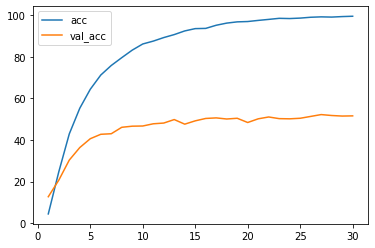

In [15]:
metrics = ['acc', 'val_acc']
plt.plot(logs['epoch'], logs[metrics])
plt.legend(metrics)
plt.show()

Since we have created checkpoints using callbacks, we can restore the best model from those checkpoints and test it.

In [16]:
resnet18 = models.resnet18(pretrained=False, num_classes=num_classes)

model = Model(resnet18, 'sgd', 'cross_entropy', 
              batch_metrics=['accuracy'], epoch_metrics=['f1'],
              device=device)

model.load_weights(os.path.join(save_path, 'best_epoch_{epoch}.ckpt').format(epoch=best_epoch))

test_loss, (test_acc, test_f1) = model.evaluate_generator(test_loader)

Test steps: 19 1.48s test_loss: 2.046891 test_acc: 49.916943 test_fscore_micro: 0.499169           


We can also use the Experiment class to train our network. This class saves checkpoints and logs as above in a directory and allows to stop and resume optimization at will. See documentation for details.

In [17]:
def experiment_train(epochs):
    # Reload the pretrained network and freeze it except for its head.
    resnet18 = models.resnet18(pretrained=True)
    resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)
    freeze_weights(resnet18)

    # Saves everything into ./saves/cub200_resnet18_experiment
    save_path = os.path.join(save_base_dir, 'cub200_resnet18_experiment')
    
    optimizer = optim.SGD(resnet18.fc.parameters(), lr=learning_rate, weight_decay=0.001)

    # Poutyne Experiment
    exp = Experiment(save_path, resnet18, device=device, optimizer=optimizer, task='classif')

    # Train
    exp.train(train_loader, valid_loader, epochs=epochs)

    # Test
    exp.test(test_loader)

Let’s train for 5 epochs.

In [18]:
experiment_train(epochs=5)

Epoch: 1/5 Train steps: 58 Val steps: 18 4.94s loss: 4.967954 acc: 5.163558 fscore_micro: 0.051636 val_loss: 4.271911 val_acc: 13.451327 val_fscore_micro: 0.134513
Epoch 1: val_acc improved from -inf to 13.45133, saving file to saves/cub200_resnet18_experiment/checkpoint_epoch_1.ckpt
Epoch: 2/5 Train steps: 58 Val steps: 18 5.12s loss: 3.715132 acc: 24.817518 fscore_micro: 0.248175 val_loss: 3.558552 val_acc: 25.132743 val_fscore_micro: 0.251327
Epoch 2: val_acc improved from 13.45133 to 25.13274, saving file to saves/cub200_resnet18_experiment/checkpoint_epoch_2.ckpt
Epoch: 3/5 Train steps: 58 Val steps: 18 5.16s loss: 2.894842 acc: 41.957286 fscore_micro: 0.419573 val_loss: 3.120051 val_acc: 31.415929 val_fscore_micro: 0.314159
Epoch 3: val_acc improved from 25.13274 to 31.41593, saving file to saves/cub200_resnet18_experiment/checkpoint_epoch_3.ckpt
Epoch: 4/5 Train steps: 58 Val steps: 18 4.91s loss: 2.351315 acc: 55.907002 fscore_micro: 0.559070 val_loss: 2.830120 val_acc: 35.6637

Let’s train for 5 more epochs (10 epochs total).

In [19]:
# Retrain for 5 more epochs
experiment_train(epochs=10)

Loading weights from saves/cub200_resnet18_experiment/checkpoint.ckpt and starting at epoch 6.
Loading optimizer state from saves/cub200_resnet18_experiment/checkpoint.optim and starting at epoch 6.
Epoch:  6/10 Train steps: 58 Val steps: 18 5.03s loss: 1.667619 acc: 71.884293 fscore_micro: 0.718843 val_loss: 2.488077 val_acc: 42.920354 val_fscore_micro: 0.429204
Epoch 6: val_acc improved from 40.00000 to 42.92035, saving file to saves/cub200_resnet18_experiment/checkpoint_epoch_6.ckpt
Epoch:  7/10 Train steps: 58 Val steps: 18 4.95s loss: 1.452402 acc: 76.507164 fscore_micro: 0.765072 val_loss: 2.388242 val_acc: 44.778761 val_fscore_micro: 0.447788
Epoch 7: val_acc improved from 42.92035 to 44.77876, saving file to saves/cub200_resnet18_experiment/checkpoint_epoch_7.ckpt
Epoch:  8/10 Train steps: 58 Val steps: 18 5.13s loss: 1.286908 acc: 79.643147 fscore_micro: 0.796431 val_loss: 2.312258 val_acc: 45.398230 val_fscore_micro: 0.453982
Epoch 8: val_acc improved from 44.77876 to 45.3982